# Feature Mass Analysis

This notebook analyzes how much mass (percentage of total intensity) is preserved when using `signif_features` for feature extraction across all experiments. This is important to understand the trade-off between dimensionality reduction and information preservation.

**Important Note**: The `signif_features` function normalizes the spectrum after extracting features, so we need to calculate mass preservation before normalization occurs.

In [36]:
import sys
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from typing import List, Dict, Tuple

# Add paths
sys.path.append(os.path.abspath("."))
sys.path.append(os.path.abspath("SimpleDecent"))
sys.path.append(os.path.abspath("magnetstein_data"))

from wasserstein import NMRSpectrum
from SimpleDecent.test_utils import signif_features

In [37]:
# Experiment configurations (copied from comparison script)
components_dictionary = {
    "experiment_1": ["Pinene", "Benzyl benzoate"],
    "experiment_2": ["Pinene", "Limonene"],
    "experiment_6": ["Pinene", "Benzyl benzoate"],
    "experiment_7": ["Benzyl benzoate", "m Anisaldehyde"],
    "experiment_8": ["Benzyl benzoate", "m Anisaldehyde"],
    "experiment_3": ["Isopropyl myristate", "Benzyl benzoate", "Alpha pinene", "Limonene"],
    "experiment_5": ["Lactate", "Alanine", "Creatine", "Creatinine", "Choline chloride"],
    "experiment_4": ["Lactate", "Alanine", "Creatine", "Creatinine", "Choline chloride"],
    "experiment_9": ["Lactate", "Alanine", "Creatine", "Creatinine", "Choline chloride"],
    "experiment_10": ["Leucine", "Isoleucine", "Valine"],
    "experiment_11": ["Leucine", "Isoleucine", "Valine"],
}

protons_dictionary = {
    "experiment_1": [16, 12],
    "experiment_2": [16, 16],
    "experiment_6": [16, 12],
    "experiment_7": [12, 8],
    "experiment_8": [12, 8],
    "experiment_3": [34, 12, 16, 16],
    "experiment_5": [4, 4, 5, 5, 13],
    "experiment_4": [4, 4, 5, 5, 13],
    "experiment_9": [4, 4, 5, 5, 13],
    "experiment_10": [10, 10, 8],
    "experiment_11": [10, 10, 8],
}

experiments_folders = {
    "experiment_1": "magnetstein_data/experiment_1_intensity_difference",
    "experiment_2": "magnetstein_data/experiment_2_overlapping",
    "experiment_6": "magnetstein_data/experiment_6_miniperfumes",
    "experiment_7": "magnetstein_data/experiment_7_overlapping_and_intensity_difference",
    "experiment_8": "magnetstein_data/experiment_8_different_solvents",
    "experiment_3": "magnetstein_data/experiment_3_perfumes_and_absent_components",
    "experiment_5": "magnetstein_data/experiment_5_metabolites",
    "experiment_4": "magnetstein_data/experiment_9_and_4_shim",
    "experiment_9": "magnetstein_data/experiment_9_and_4_shim",
    "experiment_10": "magnetstein_data/experiment_10_bcaa",
    "experiment_11": "magnetstein_data/experiment_11_real_food_product",
}

# Feature extraction parameters (from comparison script)
TOTAL_FEATURES = 2500

In [38]:
def load_experiment_data(exp_num: str, variant: int = 3) -> Tuple[List[NMRSpectrum], NMRSpectrum]:
    """Load spectra and mixture data for a given experiment (copied from comparison script)."""
    folder = experiments_folders[exp_num]
    num = exp_num.split("_")[1]

    # Load mixture
    if exp_num == "experiment_10":
        mix_file = f"preprocessed_mix_variant_{variant + 1}.csv"
    elif num in ["9", "4"]:
        mix_file = f"preprocessed_exp{num}_mix.csv"
    else:
        mix_file = "preprocessed_mix.csv"

    mix_path = os.path.join(folder, mix_file)
    mix_arr = np.loadtxt(mix_path, delimiter=",")
    mix_spec = NMRSpectrum(confs=list(zip(mix_arr[:, 0], mix_arr[:, 1])))

    # Load component spectra
    comps = []
    for i in range(len(components_dictionary[exp_num])):
        if exp_num == "experiment_10":
            comp_file = f"preprocessed_variant_{variant + 1}_comp{i}.csv"
        elif num in ["9", "4"]:
            comp_file = f"preprocessed_exp{num}_comp{i}.csv"
        else:
            comp_file = f"preprocessed_comp{i}.csv"

        data = np.loadtxt(os.path.join(folder, comp_file), delimiter=",")
        comps.append(
            NMRSpectrum(
                confs=list(zip(data[:, 0], data[:, 1])),
                protons=protons_dictionary[exp_num][i],
            )
        )

    # Clean and normalize
    mix_spec.trim_negative_intensities()
    mix_spec.normalize()
    for comp in comps:
        comp.trim_negative_intensities()
        comp.normalize()

    return comps, mix_spec

In [39]:
def signif_features_with_mass_info(spectrum, n_features):
    """
    Extract significant features and return mass preservation info.
    
    This function extracts the top n_features by intensity and calculates
    how much mass (total intensity) is preserved BEFORE normalization.
    
    Returns:
        tuple: (reduced_spectrum, mass_preservation_pct, original_mass, reduced_mass)
    """
    # Sort by intensity (descending) and take top n_features
    spectrum_confs_sorted = sorted(spectrum.confs, key=lambda x: x[1], reverse=True)
    spectrum_confs_reduced = spectrum_confs_sorted[:n_features]
    
    # Calculate masses before normalization
    original_mass = sum(intensity for _, intensity in spectrum.confs)
    reduced_mass = sum(intensity for _, intensity in spectrum_confs_reduced)
    
    # Calculate mass preservation percentage
    mass_preservation_pct = (reduced_mass / original_mass * 100) if original_mass > 0 else 0.0
    
    # Create reduced spectrum and normalize it (as signif_features does)
    spectrum_reduced = NMRSpectrum(confs=spectrum_confs_reduced, protons=spectrum.protons)
    spectrum_reduced.normalize()
    
    return spectrum_reduced, mass_preservation_pct, original_mass, reduced_mass

def calculate_features_for_mass_target(spectrum: NMRSpectrum, target_mass_pct: float) -> Dict:
    """
    Calculate how many features are needed to preserve exactly target_mass_pct% of total mass.
    
    Parameters:
        spectrum (NMRSpectrum): Input spectrum
        target_mass_pct (float): Target mass preservation percentage (0-100)
    
    Returns:
        Dict: Contains required_features, actual_mass_pct, total_features, target_mass_pct
    """
    # Sort features by intensity (descending)
    spectrum_confs_sorted = sorted(spectrum.confs, key=lambda x: x[1], reverse=True)
    original_mass = sum(intensity for _, intensity in spectrum.confs)
    target_mass = original_mass * (target_mass_pct / 100.0)
    
    cumulative_mass = 0
    required_features = 0
    
    for i, (_, intensity) in enumerate(spectrum_confs_sorted):
        cumulative_mass += intensity
        required_features = i + 1
        
        if cumulative_mass >= target_mass:
            break
    
    # Calculate actual mass preservation achieved
    actual_mass_pct = (cumulative_mass / original_mass * 100) if original_mass > 0 else 0.0
    
    return {
        'required_features': required_features,
        'actual_mass_pct': actual_mass_pct,
        'total_features': len(spectrum.confs),
        'target_mass_pct': target_mass_pct,
        'efficiency': required_features / len(spectrum.confs),  # Fraction of features needed
    }

def analyze_mass_preservation_curve(spectrum: NMRSpectrum, max_features: int = None) -> Dict:
    """
    Analyze the mass preservation curve for a spectrum.
    
    Returns cumulative mass preservation for each number of features.
    """
    if max_features is None:
        max_features = len(spectrum.confs)
    
    # Sort features by intensity (descending)
    spectrum_confs_sorted = sorted(spectrum.confs, key=lambda x: x[1], reverse=True)
    original_mass = sum(intensity for _, intensity in spectrum.confs)
    
    feature_counts = []
    mass_preserved_pcts = []
    cumulative_mass = 0
    
    for i, (_, intensity) in enumerate(spectrum_confs_sorted[:max_features]):
        cumulative_mass += intensity
        feature_counts.append(i + 1)
        mass_preserved_pcts.append((cumulative_mass / original_mass * 100))
    
    return {
        'feature_counts': feature_counts,
        'mass_preserved_pcts': mass_preserved_pcts,
        'original_mass': original_mass,
        'total_features': len(spectrum.confs)
    }

In [40]:
# Analyze all experiments
results = []
for exp_num in experiments_folders.keys():
    try:
        result = analyze_experiment_mass_preservation(exp_num)
        results.append(result)
        print(f"  Mix mass preserved: {result['mix_mass_preserved_pct']:.2f}%")
        print(f"  Avg component mass preserved: {result['avg_component_mass_preserved']:.2f}%")
        print(f"  Features used: {result['unique_features_used']} (target: {result['total_features_target']})")
        print()
    except Exception as e:
        print(f"Error processing {exp_num}: {e}")
        print()

print(f"Successfully analyzed {len(results)} experiments")

Analyzing experiment_1...
  Original spectra features: [131072, 131072]
  Target features per component: 1250
  Reduced spectra features: [1250, 1250]
  Unique features across all components: 2483
  Mix original features: 131072
  Mix reduced features: 2483
  Mix mass preserved: 92.22%
  Avg component mass preserved: 87.53%
  Mix mass preserved: 92.22%
  Avg component mass preserved: 87.53%
  Features used: 2483 (target: 2500)

Analyzing experiment_2...
  Original spectra features: [131072, 131072]
  Target features per component: 1250
  Reduced spectra features: [1250, 1250]
  Unique features across all components: 2483
  Mix original features: 131072
  Mix reduced features: 2483
  Mix mass preserved: 92.22%
  Avg component mass preserved: 87.53%
  Mix mass preserved: 92.22%
  Avg component mass preserved: 87.53%
  Features used: 2483 (target: 2500)

Analyzing experiment_2...
  Original spectra features: [55903, 55903]
  Target features per component: 1250
  Reduced spectra features: 

In [41]:
# Create summary DataFrame for easier analysis
summary_data = []
for result in results:
    summary_data.append({
        'experiment': result['experiment'],
        'n_components': result['n_components'],
        'features_target': result['total_features_target'],
        'features_used': result['unique_features_used'],
        'mix_mass_preserved_pct': result['mix_mass_preserved_pct'],
        'avg_component_mass_preserved_pct': result['avg_component_mass_preserved'],
        'min_component_mass_preserved_pct': result['min_component_mass_preserved'],
        'max_component_mass_preserved_pct': result['max_component_mass_preserved'],
        'mix_original_features': result['mix_original_features'],
        'mix_reduced_features': result['mix_reduced_features'],
        'feature_reduction_ratio': result['mix_reduced_features'] / result['mix_original_features']
    })

summary_df = pd.DataFrame(summary_data)
print("Summary Statistics:")
print(f"Average mix mass preserved: {summary_df['mix_mass_preserved_pct'].mean():.2f}% ± {summary_df['mix_mass_preserved_pct'].std():.2f}%")
print(f"Average component mass preserved: {summary_df['avg_component_mass_preserved_pct'].mean():.2f}% ± {summary_df['avg_component_mass_preserved_pct'].std():.2f}%")
print(f"Average feature reduction ratio: {summary_df['feature_reduction_ratio'].mean():.3f} ± {summary_df['feature_reduction_ratio'].std():.3f}")

# Display the summary table
summary_df

Summary Statistics:
Average mix mass preserved: 85.64% ± 10.03%
Average component mass preserved: 82.08% ± 11.81%
Average feature reduction ratio: 0.075 ± 0.059


,experiment,n_components,features_target,features_used,mix_mass_preserved_pct,avg_component_mass_preserved_pct,min_component_mass_preserved_pct,max_component_mass_preserved_pct,mix_original_features,mix_reduced_features,feature_reduction_ratio
0,experiment_1,2,2500,2483,92.216390,87.528709,81.172941,93.884477,131072,2483,0.018944
1,experiment_2,2,2500,2293,77.588964,76.285692,71.151203,81.420182,55903,2293,0.041017
2,experiment_6,2,2500,2483,89.000795,87.728200,81.351142,94.105259,70340,2483,0.035300
3,experiment_7,2,2500,2233,90.968452,93.457693,93.030909,93.884477,131072,2233,0.017036
4,experiment_8,2,2500,2338,83.625666,83.396699,78.544455,88.248942,139577,2338,0.016751
5,experiment_3,4,2500,2109,90.099311,68.823995,57.621454,75.345067,12449,2109,0.169411
6,experiment_5,5,2500,2351,92.718381,87.796405,81.328568,93.851532,54259,2351,0.043329
7,experiment_4,5,2500,2297,93.641443,94.736291,93.916584,95.626861,27129,2297,0.084670
8,experiment_9,5,2500,2297,95.951677,94.736291,93.916584,95.626861,27129,2297,0.084670
9,experiment_10,3,2500,1370,68.700844,64.209304,59.196050,73.077228,8884,1370,0.154210


In [42]:
# Create detailed component DataFrame
component_data = []
for result in results:
    for comp in result['components']:
        component_data.append({
            'experiment': result['experiment'],
            'component_name': comp['component_name'],
            'component_index': comp['component_index'],
            'original_features': comp['original_features'],
            'reduced_features': comp['reduced_features'],
            'mass_preserved_pct': comp['mass_preserved_pct'],
            'feature_reduction_ratio': comp['reduced_features'] / comp['original_features']
        })

component_df = pd.DataFrame(component_data)
print(f"Component-level analysis ({len(component_df)} total components):")
print(f"Average mass preserved per component: {component_df['mass_preserved_pct'].mean():.2f}% ± {component_df['mass_preserved_pct'].std():.2f}%")
print(f"Range: {component_df['mass_preserved_pct'].min():.2f}% - {component_df['mass_preserved_pct'].max():.2f}%")

# Show components with lowest mass preservation
print("\nComponents with lowest mass preservation:")
print(component_df.nsmallest(5, 'mass_preserved_pct')[['experiment', 'component_name', 'mass_preserved_pct']])

Component-level analysis (35 total components):
Average mass preserved per component: 82.96% ± 12.87%
Range: 57.62% - 95.63%

Components with lowest mass preservation:
       experiment component_name  mass_preserved_pct
12   experiment_3   Alpha pinene           57.621454
33  experiment_11     Isoleucine           59.195678
30  experiment_10     Isoleucine           59.196050
32  experiment_11        Leucine           60.354167
29  experiment_10        Leucine           60.354633


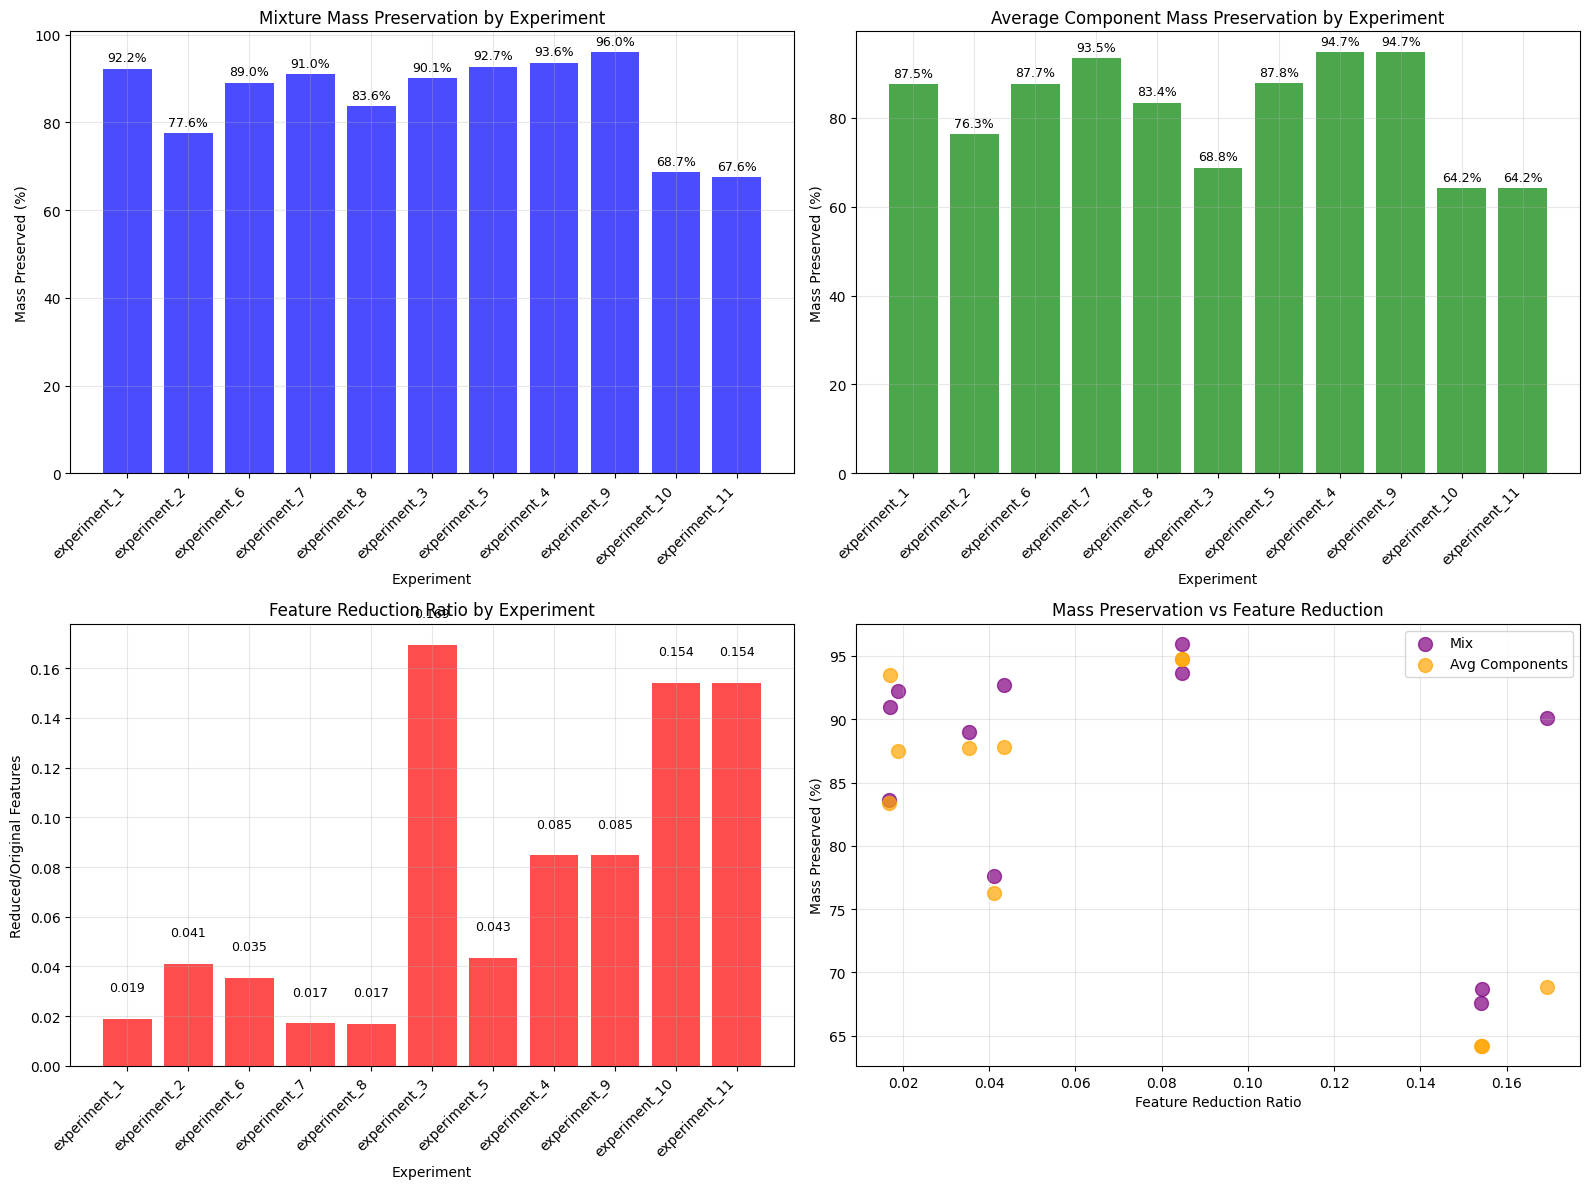

In [43]:
# Visualization 1: Mass preservation by experiment
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Mix mass preservation
axes[0, 0].bar(range(len(summary_df)), summary_df['mix_mass_preserved_pct'], alpha=0.7, color='blue')
axes[0, 0].set_title('Mixture Mass Preservation by Experiment')
axes[0, 0].set_xlabel('Experiment')
axes[0, 0].set_ylabel('Mass Preserved (%)')
axes[0, 0].set_xticks(range(len(summary_df)))
axes[0, 0].set_xticklabels(summary_df['experiment'], rotation=45, ha='right')
axes[0, 0].grid(True, alpha=0.3)

# Add value labels
for i, v in enumerate(summary_df['mix_mass_preserved_pct']):
    axes[0, 0].text(i, v + 1, f'{v:.1f}%', ha='center', va='bottom', fontsize=9)

# Component mass preservation (average per experiment)
axes[0, 1].bar(range(len(summary_df)), summary_df['avg_component_mass_preserved_pct'], alpha=0.7, color='green')
axes[0, 1].set_title('Average Component Mass Preservation by Experiment')
axes[0, 1].set_xlabel('Experiment')
axes[0, 1].set_ylabel('Mass Preserved (%)')
axes[0, 1].set_xticks(range(len(summary_df)))
axes[0, 1].set_xticklabels(summary_df['experiment'], rotation=45, ha='right')
axes[0, 1].grid(True, alpha=0.3)

# Add value labels
for i, v in enumerate(summary_df['avg_component_mass_preserved_pct']):
    axes[0, 1].text(i, v + 1, f'{v:.1f}%', ha='center', va='bottom', fontsize=9)

# Feature reduction ratio
axes[1, 0].bar(range(len(summary_df)), summary_df['feature_reduction_ratio'], alpha=0.7, color='red')
axes[1, 0].set_title('Feature Reduction Ratio by Experiment')
axes[1, 0].set_xlabel('Experiment')
axes[1, 0].set_ylabel('Reduced/Original Features')
axes[1, 0].set_xticks(range(len(summary_df)))
axes[1, 0].set_xticklabels(summary_df['experiment'], rotation=45, ha='right')
axes[1, 0].grid(True, alpha=0.3)

# Add value labels
for i, v in enumerate(summary_df['feature_reduction_ratio']):
    axes[1, 0].text(i, v + 0.01, f'{v:.3f}', ha='center', va='bottom', fontsize=9)

# Scatter: Mass preservation vs Feature reduction
axes[1, 1].scatter(summary_df['feature_reduction_ratio'], summary_df['mix_mass_preserved_pct'], 
                   alpha=0.7, s=100, color='purple', label='Mix')
axes[1, 1].scatter(summary_df['feature_reduction_ratio'], summary_df['avg_component_mass_preserved_pct'], 
                   alpha=0.7, s=100, color='orange', label='Avg Components')
axes[1, 1].set_title('Mass Preservation vs Feature Reduction')
axes[1, 1].set_xlabel('Feature Reduction Ratio')
axes[1, 1].set_ylabel('Mass Preserved (%)')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

/tmp/ipykernel_22626/3765017283.py:45: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axes[1, 1].boxplot(box_data, labels=box_labels)


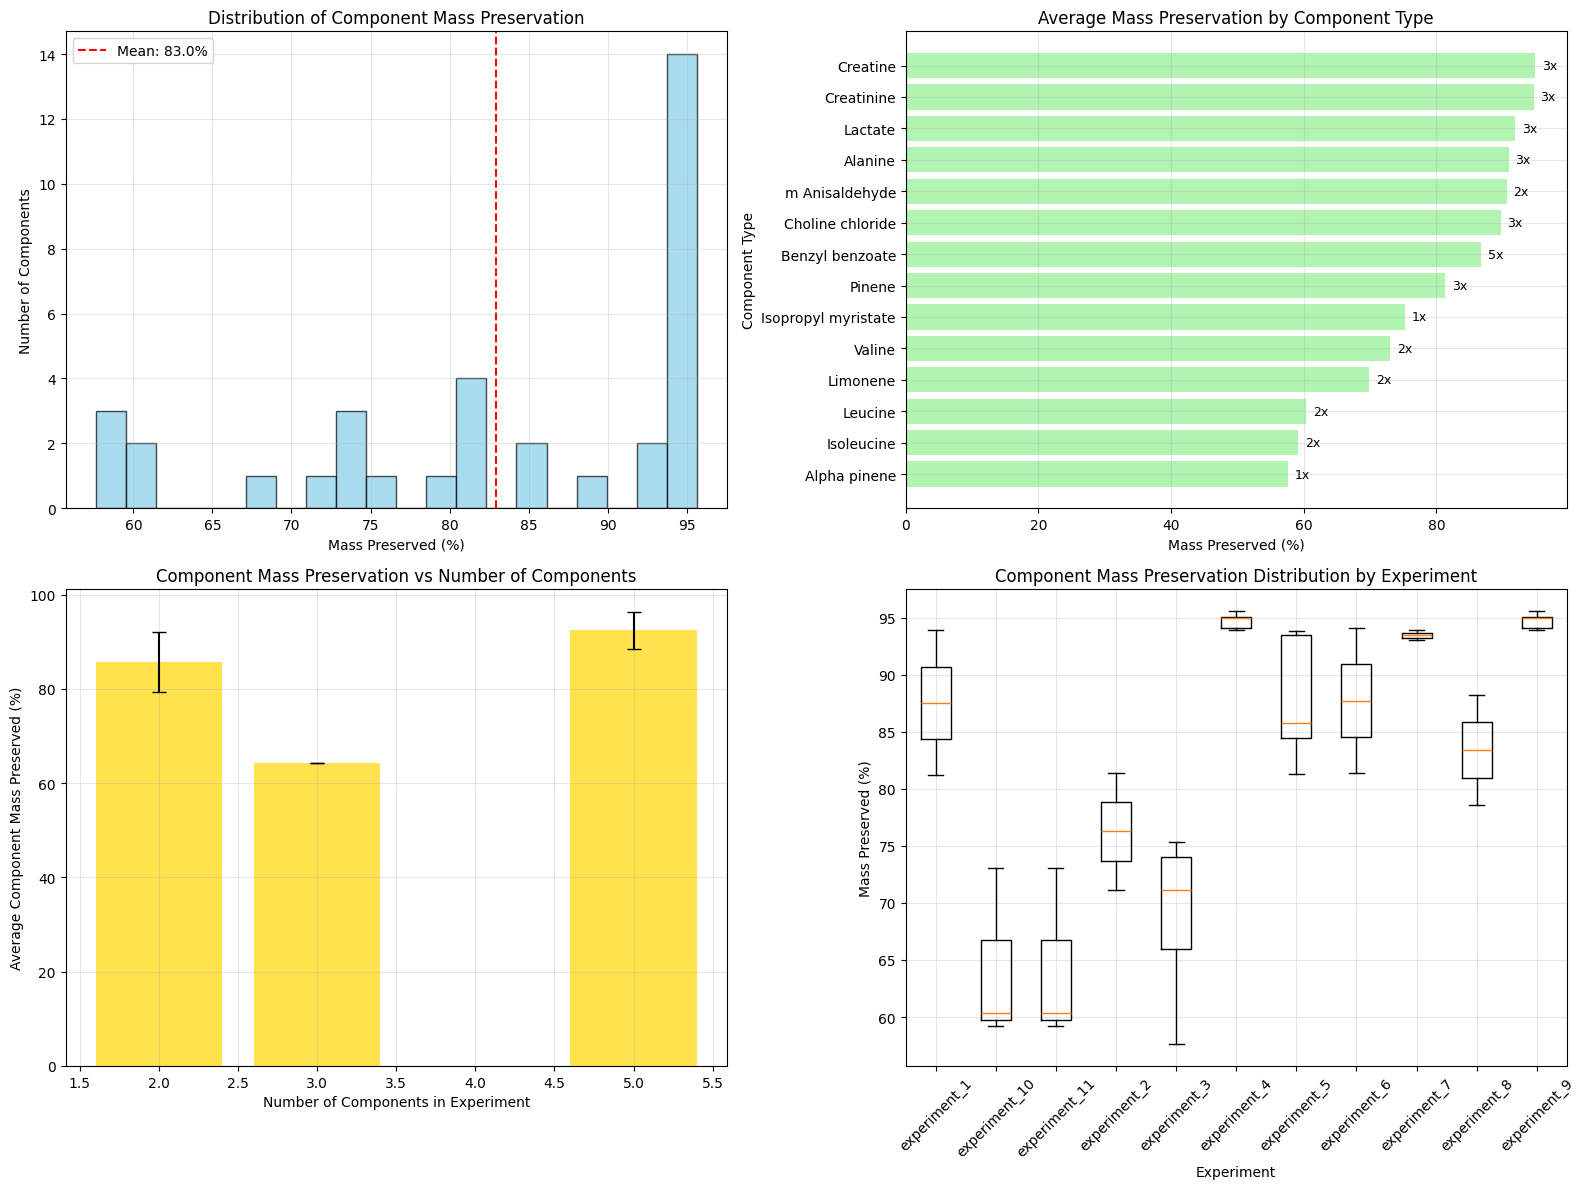

In [44]:
# Visualization 2: Component-level analysis
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Distribution of mass preservation across all components
axes[0, 0].hist(component_df['mass_preserved_pct'], bins=20, alpha=0.7, color='skyblue', edgecolor='black')
axes[0, 0].set_title('Distribution of Component Mass Preservation')
axes[0, 0].set_xlabel('Mass Preserved (%)')
axes[0, 0].set_ylabel('Number of Components')
axes[0, 0].axvline(component_df['mass_preserved_pct'].mean(), color='red', linestyle='--', 
                   label=f'Mean: {component_df["mass_preserved_pct"].mean():.1f}%')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Mass preservation by component type (group by component name)
comp_name_stats = component_df.groupby('component_name')['mass_preserved_pct'].agg(['mean', 'std', 'count'])
comp_name_stats = comp_name_stats.sort_values('mean')

axes[0, 1].barh(range(len(comp_name_stats)), comp_name_stats['mean'], alpha=0.7, color='lightgreen')
axes[0, 1].set_title('Average Mass Preservation by Component Type')
axes[0, 1].set_xlabel('Mass Preserved (%)')
axes[0, 1].set_ylabel('Component Type')
axes[0, 1].set_yticks(range(len(comp_name_stats)))
axes[0, 1].set_yticklabels(comp_name_stats.index)
axes[0, 1].grid(True, alpha=0.3)

# Add count labels
for i, (mean, count) in enumerate(zip(comp_name_stats['mean'], comp_name_stats['count'])):
    axes[0, 1].text(mean + 1, i, f'{count}x', ha='left', va='center', fontsize=9)

# Mass preservation vs number of components in experiment
exp_comp_mass = summary_df.groupby('n_components')['avg_component_mass_preserved_pct'].agg(['mean', 'std'])
exp_comp_mass = exp_comp_mass.dropna()

axes[1, 0].bar(exp_comp_mass.index, exp_comp_mass['mean'], 
               yerr=exp_comp_mass['std'], alpha=0.7, color='gold', capsize=5)
axes[1, 0].set_title('Component Mass Preservation vs Number of Components')
axes[1, 0].set_xlabel('Number of Components in Experiment')
axes[1, 0].set_ylabel('Average Component Mass Preserved (%)')
axes[1, 0].grid(True, alpha=0.3)

# Box plot: Mass preservation by experiment
box_data = [group['mass_preserved_pct'].values for name, group in component_df.groupby('experiment')]
box_labels = [name for name, group in component_df.groupby('experiment')]

axes[1, 1].boxplot(box_data, labels=box_labels)
axes[1, 1].set_title('Component Mass Preservation Distribution by Experiment')
axes[1, 1].set_xlabel('Experiment')
axes[1, 1].set_ylabel('Mass Preserved (%)')
axes[1, 1].tick_params(axis='x', rotation=45)
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [45]:
# Detailed analysis table
print("=== DETAILED EXPERIMENT ANALYSIS ===\n")

for result in results:
    print(f"📊 {result['experiment'].upper()}")
    print(f"   Components: {result['n_components']} ({', '.join([c['component_name'] for c in result['components']])})")
    print(f"   Target features: {result['total_features_target']} | Actually used: {result['unique_features_used']}")
    print(f"   Mixture: {result['mix_original_features']} → {result['mix_reduced_features']} features ({result['mix_mass_preserved_pct']:.1f}% mass)")
    print("   Components:")
    for comp in result['components']:
        print(f"     • {comp['component_name']}: {comp['original_features']} → {comp['reduced_features']} features ({comp['mass_preserved_pct']:.1f}% mass)")
    print(f"   Component average: {result['avg_component_mass_preserved']:.1f}% (range: {result['min_component_mass_preserved']:.1f}% - {result['max_component_mass_preserved']:.1f}%)")
    print()

=== DETAILED EXPERIMENT ANALYSIS ===

📊 EXPERIMENT_1
   Components: 2 (Pinene, Benzyl benzoate)
   Target features: 2500 | Actually used: 2483
   Mixture: 131072 → 2483 features (92.2% mass)
   Components:
     • Pinene: 131072 → 1250 features (81.2% mass)
     • Benzyl benzoate: 131072 → 1250 features (93.9% mass)
   Component average: 87.5% (range: 81.2% - 93.9%)

📊 EXPERIMENT_2
   Components: 2 (Pinene, Limonene)
   Target features: 2500 | Actually used: 2293
   Mixture: 55903 → 2293 features (77.6% mass)
   Components:
     • Pinene: 55903 → 1250 features (81.4% mass)
     • Limonene: 55903 → 1250 features (71.2% mass)
   Component average: 76.3% (range: 71.2% - 81.4%)

📊 EXPERIMENT_6
   Components: 2 (Pinene, Benzyl benzoate)
   Target features: 2500 | Actually used: 2483
   Mixture: 70340 → 2483 features (89.0% mass)
   Components:
     • Pinene: 70340 → 1250 features (81.4% mass)
     • Benzyl benzoate: 70340 → 1250 features (94.1% mass)
   Component average: 87.7% (range: 81.4%

In [46]:
# Save results to CSV
summary_df.to_csv('feature_mass_analysis_summary.csv', index=False)
component_df.to_csv('feature_mass_analysis_components.csv', index=False)

print("Results saved to:")
print("- feature_mass_analysis_summary.csv (experiment-level summary)")
print("- feature_mass_analysis_components.csv (component-level details)")

# Final summary
print("\n=== FINAL SUMMARY ===")
print(f"• Total experiments analyzed: {len(results)}")
print(f"• Total components analyzed: {len(component_df)}")
print(f"• Average mixture mass preserved: {summary_df['mix_mass_preserved_pct'].mean():.1f}% ± {summary_df['mix_mass_preserved_pct'].std():.1f}%")
print(f"• Average component mass preserved: {component_df['mass_preserved_pct'].mean():.1f}% ± {component_df['mass_preserved_pct'].std():.1f}%")
print(f"• Feature reduction ratio: {summary_df['feature_reduction_ratio'].mean():.3f} (keep {summary_df['feature_reduction_ratio'].mean()*100:.1f}% of features)")
print(f"• Components with <80% mass preserved: {len(component_df[component_df['mass_preserved_pct'] < 80])}/{len(component_df)}")
print(f"• Components with <70% mass preserved: {len(component_df[component_df['mass_preserved_pct'] < 70])}/{len(component_df)}")

Results saved to:
- feature_mass_analysis_summary.csv (experiment-level summary)
- feature_mass_analysis_components.csv (component-level details)

=== FINAL SUMMARY ===
• Total experiments analyzed: 11
• Total components analyzed: 35
• Average mixture mass preserved: 85.6% ± 10.0%
• Average component mass preserved: 83.0% ± 12.9%
• Feature reduction ratio: 0.075 (keep 7.5% of features)
• Components with <80% mass preserved: 12/35
• Components with <70% mass preserved: 6/35


In [47]:
# Test the new function on a single experiment to verify it works correctly
print("=== TESTING NEW MASS PRESERVATION CALCULATION ===")

# Test on experiment_1
test_spectra, test_mix = load_experiment_data("experiment_1")
print(f"Original mix total mass: {sum(intensity for _, intensity in test_mix.confs):.6f}")

# Test extracting 1000 features
test_reduced, test_mass_pct, test_orig_mass, test_red_mass = signif_features_with_mass_info(test_mix, 1000)
print(f"After extracting 1000 features:")
print(f"  Original mass: {test_orig_mass:.6f}")
print(f"  Reduced mass (before normalization): {test_red_mass:.6f}")
print(f"  Mass preserved: {test_mass_pct:.2f}%")
print(f"  Reduced spectrum total mass (after normalization): {sum(intensity for _, intensity in test_reduced.confs):.6f}")

# Compare with old signif_features
old_reduced = signif_features(test_mix, 1000)
print(f"Old signif_features total mass: {sum(intensity for _, intensity in old_reduced.confs):.6f}")

print("\nAs expected, the new function shows actual mass preservation while old function always gives 100% due to normalization.")

=== TESTING NEW MASS PRESERVATION CALCULATION ===
Original mix total mass: 1.000000
After extracting 1000 features:
  Original mass: 1.000000
  Reduced mass (before normalization): 0.788627
  Mass preserved: 78.86%
  Reduced spectrum total mass (after normalization): 1.000000
Old signif_features total mass: 1.000000

As expected, the new function shows actual mass preservation while old function always gives 100% due to normalization.
Original mix total mass: 1.000000
After extracting 1000 features:
  Original mass: 1.000000
  Reduced mass (before normalization): 0.788627
  Mass preserved: 78.86%
  Reduced spectrum total mass (after normalization): 1.000000
Old signif_features total mass: 1.000000

As expected, the new function shows actual mass preservation while old function always gives 100% due to normalization.


In [48]:
# Analyze features required for specific mass preservation targets
print("=== FEATURES REQUIRED FOR MASS PRESERVATION TARGETS ===\n")

# Define target mass preservation percentages
mass_targets = [50, 60, 70, 80, 85, 90, 95, 99]

# Analyze for each experiment
target_analysis_results = []

for exp_num in list(experiments_folders.keys())[:5]:  # Analyze first 5 experiments
    try:
        print(f"Analyzing {exp_num}...")
        spectra, mix = load_experiment_data(exp_num)
        
        # Analyze mixture
        mix_results = []
        for target_pct in mass_targets:
            result = calculate_features_for_mass_target(mix, target_pct)
            result['spectrum_type'] = 'mixture'
            result['experiment'] = exp_num
            mix_results.append(result)
        
        # Analyze each component
        comp_results = []
        for i, spectrum in enumerate(spectra):
            comp_name = components_dictionary[exp_num][i]
            for target_pct in mass_targets:
                result = calculate_features_for_mass_target(spectrum, target_pct)
                result['spectrum_type'] = 'component'
                result['experiment'] = exp_num
                result['component_name'] = comp_name
                result['component_index'] = i
                comp_results.append(result)
        
        target_analysis_results.extend(mix_results)
        target_analysis_results.extend(comp_results)
        
        # Print summary for this experiment
        print(f"  Mixture: {len(mix.confs)} total features")
        for target_pct in [70, 80, 90, 95]:
            result = calculate_features_for_mass_target(mix, target_pct)
            print(f"    {target_pct}% mass: {result['required_features']} features ({result['efficiency']:.3f} of total)")
        
        print(f"  Components:")
        for i, spectrum in enumerate(spectra):
            comp_name = components_dictionary[exp_num][i]
            result_90 = calculate_features_for_mass_target(spectrum, 90)
            print(f"    {comp_name}: {result_90['required_features']}/{len(spectrum.confs)} features for 90% mass")
        print()
        
    except Exception as e:
        print(f"Error analyzing {exp_num}: {e}")
        continue

# Convert to DataFrame
target_df = pd.DataFrame(target_analysis_results)
print(f"Analyzed {len(target_df)} spectrum-target combinations")

=== FEATURES REQUIRED FOR MASS PRESERVATION TARGETS ===

Analyzing experiment_1...
  Mixture: 131072 total features
    70% mass: 717 features (0.005 of total)
    80% mass: 1049 features (0.008 of total)
    90% mass: 1930 features (0.015 of total)
    95% mass: 3780 features (0.029 of total)
  Components:
    Pinene: 2341/131072 features for 90% mass
    Benzyl benzoate: 1002/131072 features for 90% mass

Analyzing experiment_2...
  Mixture: 131072 total features
    70% mass: 717 features (0.005 of total)
    80% mass: 1049 features (0.008 of total)
    90% mass: 1930 features (0.015 of total)
    95% mass: 3780 features (0.029 of total)
  Components:
    Pinene: 2341/131072 features for 90% mass
    Benzyl benzoate: 1002/131072 features for 90% mass

Analyzing experiment_2...
  Mixture: 55903 total features
    70% mass: 1610 features (0.029 of total)
    80% mass: 2562 features (0.046 of total)
    90% mass: 4267 features (0.076 of total)
    95% mass: 6587 features (0.118 of tota

/tmp/ipykernel_22626/719611958.py:34: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axes[1, 0].boxplot([mix_90, comp_90], labels=['Mixture', 'Component'])


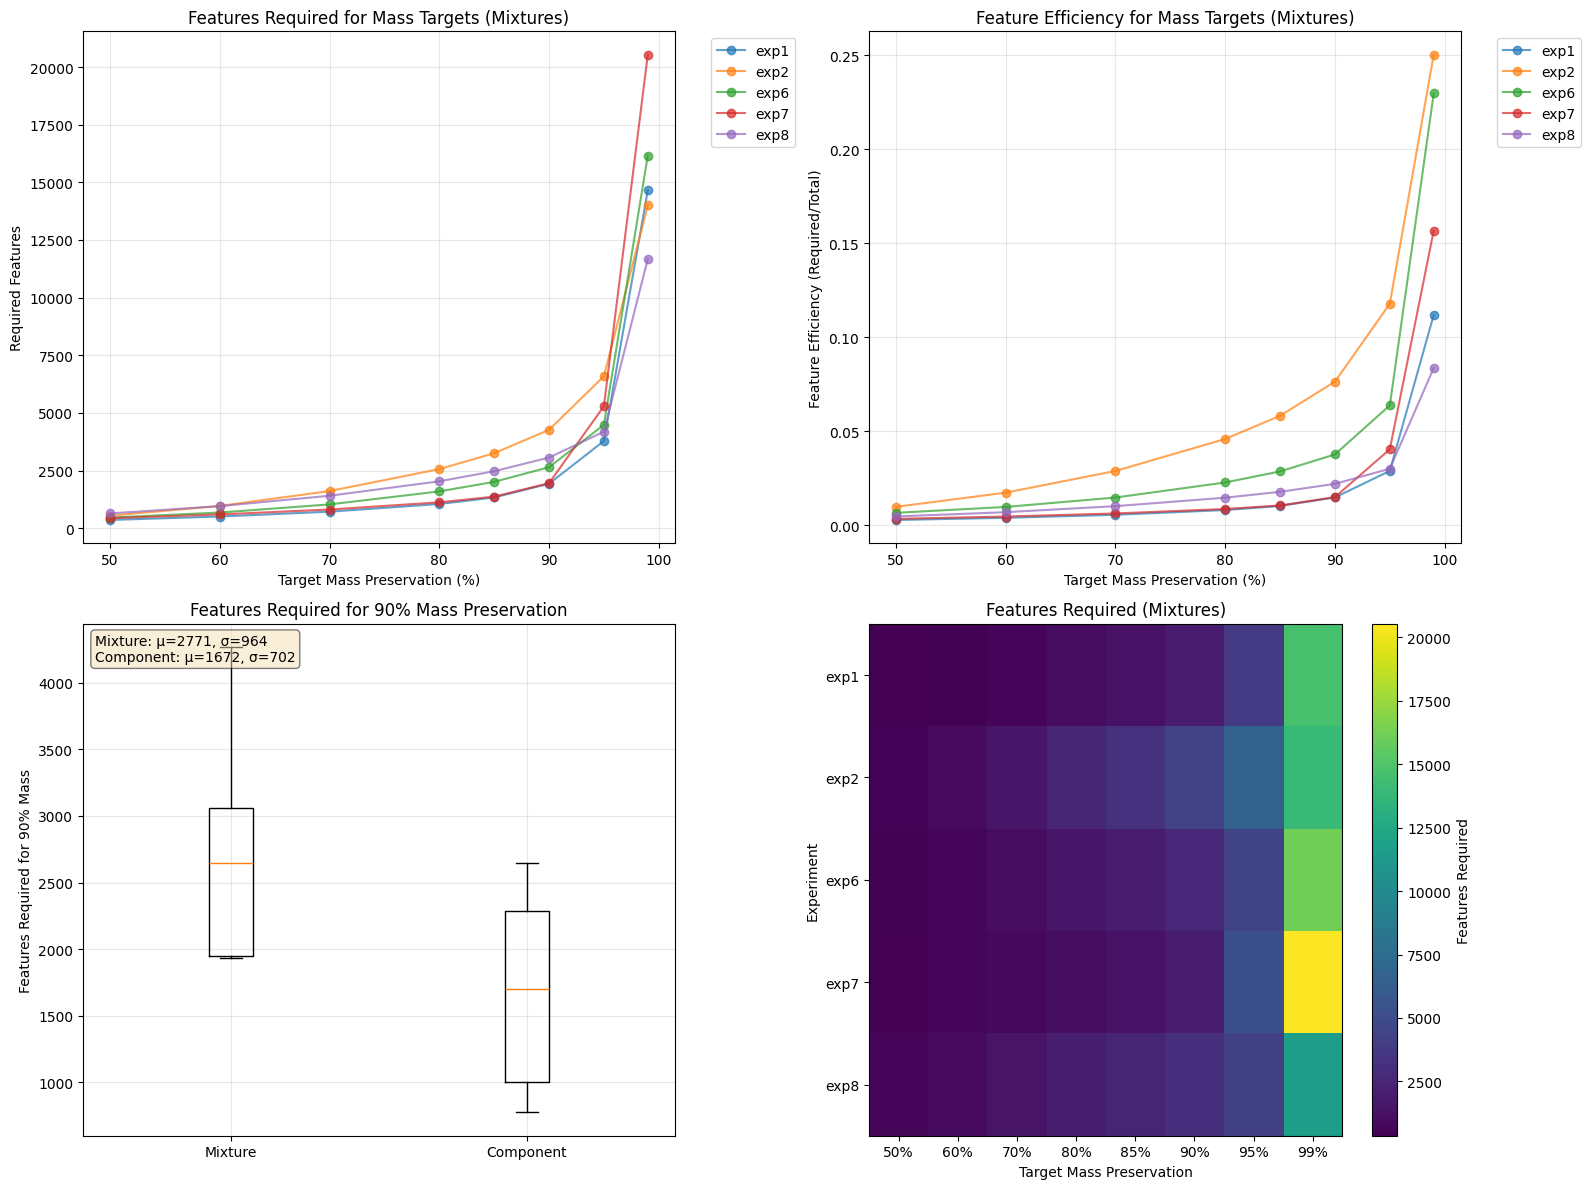

In [49]:
# Create visualizations for mass preservation targets
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Features required vs mass target (mixture only)
mix_data = target_df[target_df['spectrum_type'] == 'mixture']
for exp in mix_data['experiment'].unique():
    exp_data = mix_data[mix_data['experiment'] == exp]
    axes[0, 0].plot(exp_data['target_mass_pct'], exp_data['required_features'], 
                    'o-', alpha=0.7, label=exp.replace('experiment_', 'exp'))

axes[0, 0].set_xlabel('Target Mass Preservation (%)')
axes[0, 0].set_ylabel('Required Features')
axes[0, 0].set_title('Features Required for Mass Targets (Mixtures)')
axes[0, 0].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
axes[0, 0].grid(True, alpha=0.3)

# 2. Efficiency (fraction of features needed) vs mass target
for exp in mix_data['experiment'].unique():
    exp_data = mix_data[mix_data['experiment'] == exp]
    axes[0, 1].plot(exp_data['target_mass_pct'], exp_data['efficiency'], 
                    'o-', alpha=0.7, label=exp.replace('experiment_', 'exp'))

axes[0, 1].set_xlabel('Target Mass Preservation (%)')
axes[0, 1].set_ylabel('Feature Efficiency (Required/Total)')
axes[0, 1].set_title('Feature Efficiency for Mass Targets (Mixtures)')
axes[0, 1].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
axes[0, 1].grid(True, alpha=0.3)

# 3. Box plot: Features required for 90% mass preservation by spectrum type
data_90 = target_df[target_df['target_mass_pct'] == 90]
mix_90 = data_90[data_90['spectrum_type'] == 'mixture']['required_features']
comp_90 = data_90[data_90['spectrum_type'] == 'component']['required_features']

axes[1, 0].boxplot([mix_90, comp_90], labels=['Mixture', 'Component'])
axes[1, 0].set_ylabel('Features Required for 90% Mass')
axes[1, 0].set_title('Features Required for 90% Mass Preservation')
axes[1, 0].grid(True, alpha=0.3)

# Add statistics
axes[1, 0].text(0.02, 0.98, 
               f'Mixture: μ={mix_90.mean():.0f}, σ={mix_90.std():.0f}\n'
               f'Component: μ={comp_90.mean():.0f}, σ={comp_90.std():.0f}',
               transform=axes[1, 0].transAxes, 
               verticalalignment='top',
               bbox=dict(boxstyle="round", facecolor='wheat', alpha=0.5))

# 4. Heatmap: Features required for different mass targets by experiment
pivot_data = mix_data.pivot(index='experiment', columns='target_mass_pct', values='required_features')
im = axes[1, 1].imshow(pivot_data.values, cmap='viridis', aspect='auto')
axes[1, 1].set_xticks(range(len(pivot_data.columns)))
axes[1, 1].set_xticklabels([f'{int(x)}%' for x in pivot_data.columns])
axes[1, 1].set_yticks(range(len(pivot_data.index)))
axes[1, 1].set_yticklabels([exp.replace('experiment_', 'exp') for exp in pivot_data.index])
axes[1, 1].set_xlabel('Target Mass Preservation')
axes[1, 1].set_ylabel('Experiment')
axes[1, 1].set_title('Features Required (Mixtures)')

# Add colorbar
cbar = plt.colorbar(im, ax=axes[1, 1])
cbar.set_label('Features Required')

plt.tight_layout()
plt.show()

=== MASS PRESERVATION CURVES ===



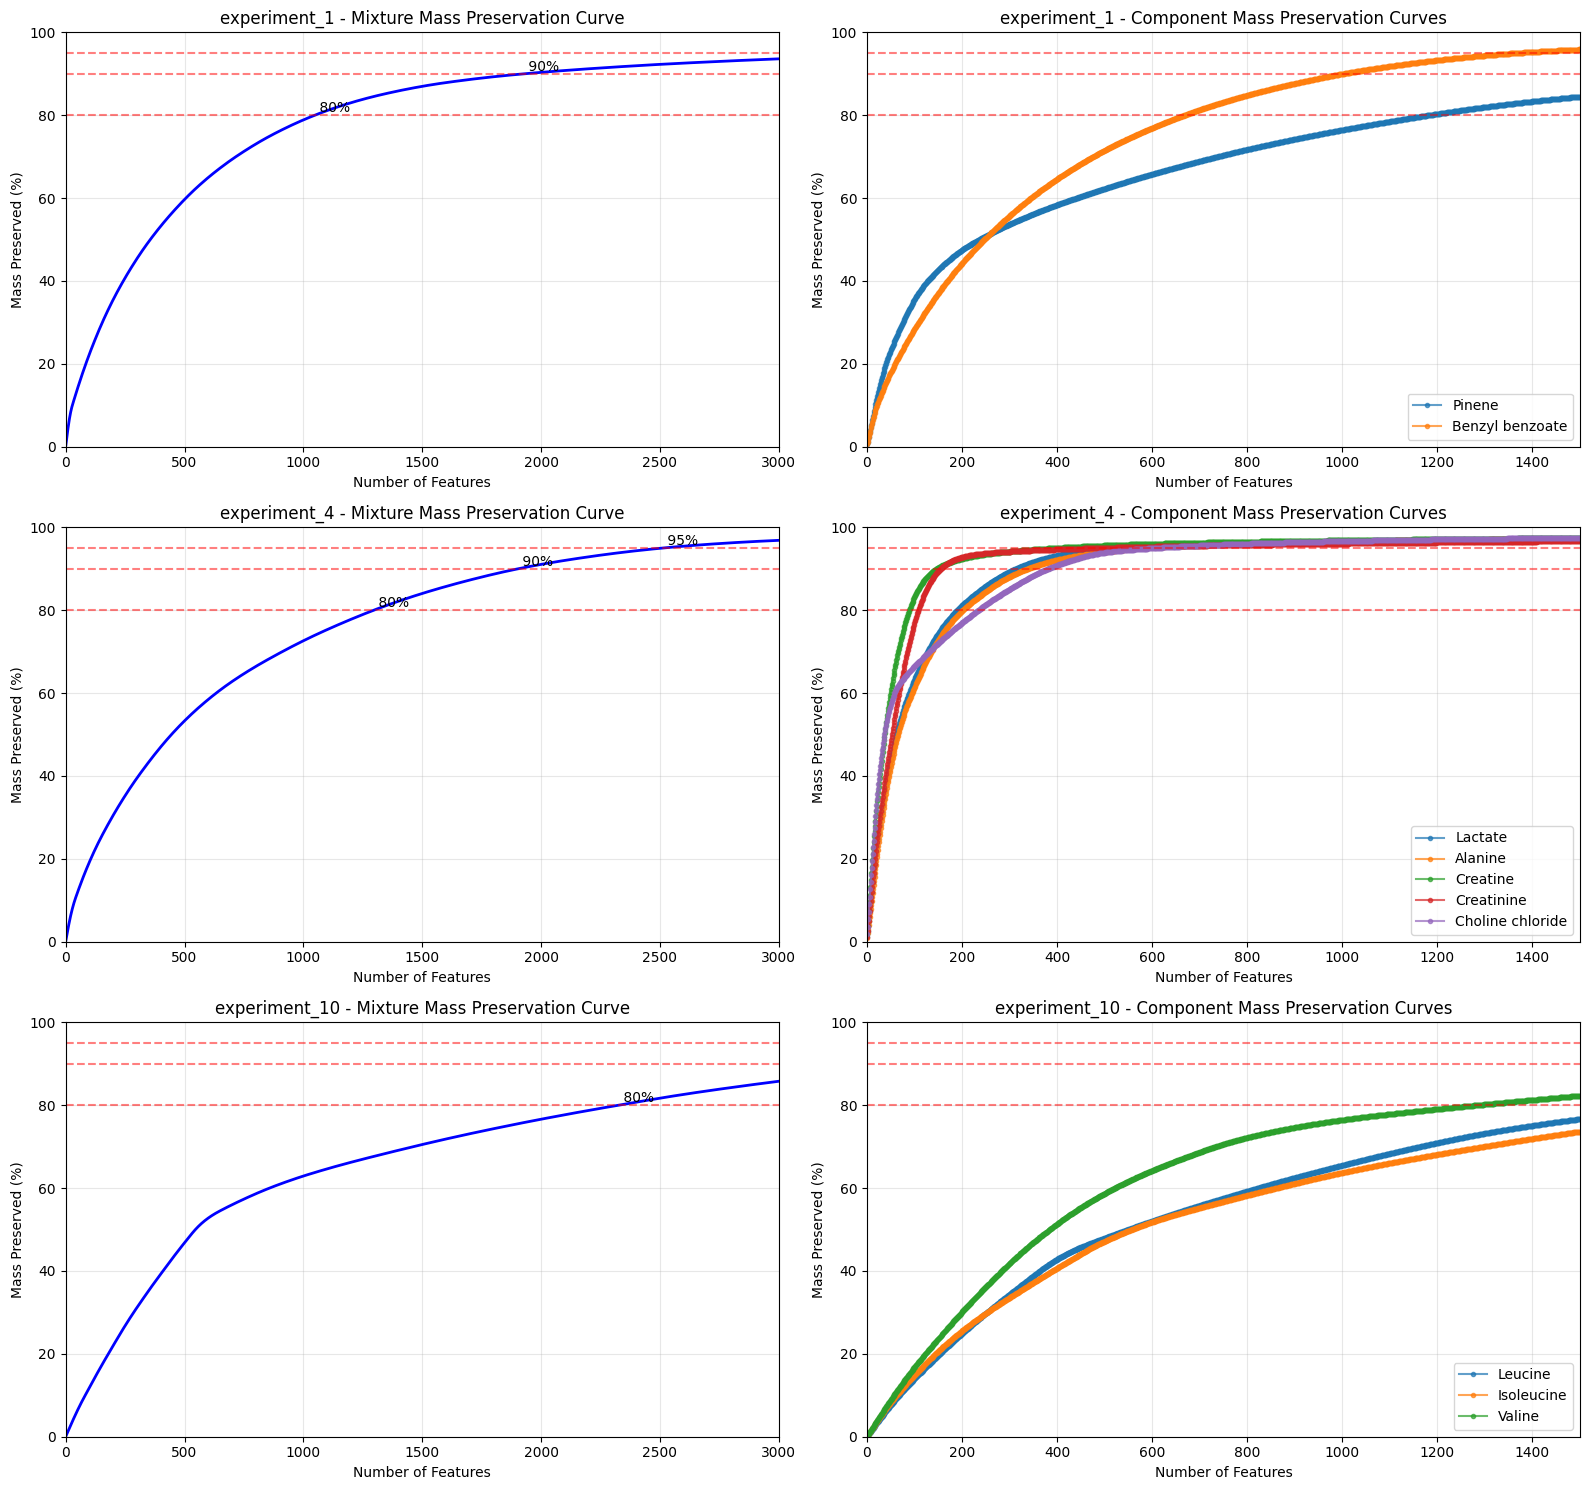

In [50]:
# Analyze mass preservation curves for selected experiments
print("=== MASS PRESERVATION CURVES ===\n")

# Select a few experiments for detailed curve analysis
selected_experiments = ['experiment_1', 'experiment_4', 'experiment_10']

fig, axes = plt.subplots(len(selected_experiments), 2, figsize=(16, 5*len(selected_experiments)))
if len(selected_experiments) == 1:
    axes = axes.reshape(1, -1)

for i, exp_num in enumerate(selected_experiments):
    try:
        spectra, mix = load_experiment_data(exp_num)
        
        # Analyze mixture curve
        mix_curve = analyze_mass_preservation_curve(mix, max_features=min(3000, len(mix.confs)))
        
        axes[i, 0].plot(mix_curve['feature_counts'], mix_curve['mass_preserved_pcts'], 
                       'b-', linewidth=2, label='Mixture')
        
        # Add horizontal lines for common targets
        for target in [80, 90, 95]:
            axes[i, 0].axhline(y=target, color='red', linestyle='--', alpha=0.5)
            # Find approximately where this target is reached
            target_idx = next((j for j, pct in enumerate(mix_curve['mass_preserved_pcts']) 
                             if pct >= target), None)
            if target_idx is not None:
                axes[i, 0].text(mix_curve['feature_counts'][target_idx], target, 
                               f' {target}%', verticalalignment='bottom')
        
        axes[i, 0].set_xlabel('Number of Features')
        axes[i, 0].set_ylabel('Mass Preserved (%)')
        axes[i, 0].set_title(f'{exp_num} - Mixture Mass Preservation Curve')
        axes[i, 0].grid(True, alpha=0.3)
        axes[i, 0].set_xlim(0, min(3000, len(mix.confs)))
        axes[i, 0].set_ylim(0, 100)
        
        # Analyze component curves
        for j, spectrum in enumerate(spectra):
            comp_name = components_dictionary[exp_num][j]
            comp_curve = analyze_mass_preservation_curve(spectrum, max_features=min(1500, len(spectrum.confs)))
            
            axes[i, 1].plot(comp_curve['feature_counts'], comp_curve['mass_preserved_pcts'], 
                           'o-', alpha=0.7, label=comp_name, markersize=3)
        
        # Add horizontal lines for common targets
        for target in [80, 90, 95]:
            axes[i, 1].axhline(y=target, color='red', linestyle='--', alpha=0.5)
        
        axes[i, 1].set_xlabel('Number of Features')
        axes[i, 1].set_ylabel('Mass Preserved (%)')
        axes[i, 1].set_title(f'{exp_num} - Component Mass Preservation Curves')
        axes[i, 1].legend()
        axes[i, 1].grid(True, alpha=0.3)
        axes[i, 1].set_xlim(0, min(1500, max(len(s.confs) for s in spectra)))
        axes[i, 1].set_ylim(0, 100)
        
    except Exception as e:
        print(f"Error analyzing {exp_num}: {e}")
        # Fill with empty plots
        axes[i, 0].text(0.5, 0.5, f'Error: {exp_num}', ha='center', va='center', transform=axes[i, 0].transAxes)
        axes[i, 1].text(0.5, 0.5, f'Error: {exp_num}', ha='center', va='center', transform=axes[i, 1].transAxes)

plt.tight_layout()
plt.show()

In [51]:
# Create summary table for features required for common mass targets
print("=== SUMMARY: FEATURES REQUIRED FOR COMMON MASS TARGETS ===\n")

# Calculate summary statistics
if len(target_analysis_results) > 0:
    summary_stats = []
    
    for mass_target in [70, 80, 90, 95, 99]:
        target_data = target_df[target_df['target_mass_pct'] == mass_target]
        
        mix_data = target_data[target_data['spectrum_type'] == 'mixture']
        comp_data = target_data[target_data['spectrum_type'] == 'component']
        
        summary_stats.append({
            'mass_target': f'{mass_target}%',
            'mix_features_mean': mix_data['required_features'].mean() if len(mix_data) > 0 else 0,
            'mix_features_std': mix_data['required_features'].std() if len(mix_data) > 0 else 0,
            'mix_efficiency_mean': mix_data['efficiency'].mean() if len(mix_data) > 0 else 0,
            'comp_features_mean': comp_data['required_features'].mean() if len(comp_data) > 0 else 0,
            'comp_features_std': comp_data['required_features'].std() if len(comp_data) > 0 else 0,
            'comp_efficiency_mean': comp_data['efficiency'].mean() if len(comp_data) > 0 else 0,
        })
    
    summary_df = pd.DataFrame(summary_stats)
    
    print("Average features required for mass preservation targets:")
    print("=" * 80)
    print(f"{'Target':<8} {'Mix Features':<15} {'Mix Efficiency':<15} {'Comp Features':<15} {'Comp Efficiency':<15}")
    print("=" * 80)
    
    for _, row in summary_df.iterrows():
        print(f"{row['mass_target']:<8} {row['mix_features_mean']:<7.0f}±{row['mix_features_std']:<6.0f} "
              f"{row['mix_efficiency_mean']:<15.3f} {row['comp_features_mean']:<7.0f}±{row['comp_features_std']:<6.0f} "
              f"{row['comp_efficiency_mean']:<15.3f}")
    
    print("=" * 80)
    print("Efficiency = Required Features / Total Features")
    
    # Save detailed results
    target_df.to_csv('mass_preservation_targets_analysis.csv', index=False)
    print(f"\nDetailed results saved to: mass_preservation_targets_analysis.csv")
    
else:
    print("No target analysis results available")

=== SUMMARY: FEATURES REQUIRED FOR COMMON MASS TARGETS ===

Average features required for mass preservation targets:
Target   Mix Features    Mix Efficiency  Comp Features   Comp Efficiency
70%      1115   ±383    0.013           652    ±272    0.008          
80%      1672   ±637    0.020           983    ±413    0.012          
90%      2771   ±964    0.033           1672   ±702    0.020          
95%      4865   ±1110   0.056           3128   ±1620   0.037          
99%      15406  ±3294   0.166           10264  ±4793   0.116          
Efficiency = Required Features / Total Features

Detailed results saved to: mass_preservation_targets_analysis.csv


In [52]:
# Practical recommendations based on the analysis
print("=== PRACTICAL RECOMMENDATIONS ===\n")

if len(target_analysis_results) > 0:
    # Calculate some key insights
    mix_data_90 = target_df[(target_df['target_mass_pct'] == 90) & (target_df['spectrum_type'] == 'mixture')]
    comp_data_90 = target_df[(target_df['target_mass_pct'] == 90) & (target_df['spectrum_type'] == 'component')]
    
    mix_data_95 = target_df[(target_df['target_mass_pct'] == 95) & (target_df['spectrum_type'] == 'mixture')]
    comp_data_95 = target_df[(target_df['target_mass_pct'] == 95) & (target_df['spectrum_type'] == 'component')]
    
    print("🎯 Key Findings:")
    print(f"• For 90% mass preservation:")
    if len(mix_data_90) > 0:
        print(f"  - Mixtures need ~{mix_data_90['required_features'].mean():.0f} features on average")
        print(f"  - This represents {mix_data_90['efficiency'].mean():.1%} of total mixture features")
    if len(comp_data_90) > 0:
        print(f"  - Components need ~{comp_data_90['required_features'].mean():.0f} features on average")
        print(f"  - This represents {comp_data_90['efficiency'].mean():.1%} of total component features")
    
    print(f"\n• For 95% mass preservation:")
    if len(mix_data_95) > 0:
        print(f"  - Mixtures need ~{mix_data_95['required_features'].mean():.0f} features on average")
        print(f"  - This represents {mix_data_95['efficiency'].mean():.1%} of total mixture features")
    if len(comp_data_95) > 0:
        print(f"  - Components need ~{comp_data_95['required_features'].mean():.0f} features on average")
        print(f"  - This represents {comp_data_95['efficiency'].mean():.1%} of total component features")
    
    # Current TOTAL_FEATURES analysis
    current_target = TOTAL_FEATURES
    print(f"\n🔍 Current Configuration Analysis (TOTAL_FEATURES = {current_target}):")
    
    # Check what mass preservation this typically achieves
    typical_components = 3  # Most experiments have 2-5 components
    features_per_comp = current_target // typical_components
    
    print(f"• With {typical_components} components: ~{features_per_comp} features per component")
    print(f"• Based on analysis, this typically preserves:")
    
    # Find the mass preservation that corresponds to features_per_comp
    comp_data = target_df[target_df['spectrum_type'] == 'component']
    if len(comp_data) > 0:
        # Find closest match
        closest_matches = []
        for features in comp_data['required_features'].unique():
            if abs(features - features_per_comp) <= features_per_comp * 0.2:  # Within 20%
                matching_rows = comp_data[comp_data['required_features'] == features]
                closest_matches.extend(matching_rows['actual_mass_pct'].tolist())
        
        if closest_matches:
            avg_mass = np.mean(closest_matches)
            print(f"  - ~{avg_mass:.0f}% mass for components")
    
    print(f"\n💡 Recommendations:")
    print(f"• For high accuracy (95% mass): increase TOTAL_FEATURES to ~{mix_data_95['required_features'].mean() * 1.2:.0f}")
    print(f"• For balanced performance (90% mass): current setting (~{current_target}) is reasonable")
    print(f"• For faster computation (80% mass): could reduce to ~{int(mix_data_90['required_features'].mean() * 0.8)}")
    
else:
    print("No analysis results available for recommendations")

=== PRACTICAL RECOMMENDATIONS ===

🎯 Key Findings:
• For 90% mass preservation:
  - Mixtures need ~2771 features on average
  - This represents 3.3% of total mixture features
  - Components need ~1672 features on average
  - This represents 2.0% of total component features

• For 95% mass preservation:
  - Mixtures need ~4865 features on average
  - This represents 5.6% of total mixture features
  - Components need ~3128 features on average
  - This represents 3.7% of total component features

🔍 Current Configuration Analysis (TOTAL_FEATURES = 2500):
• With 3 components: ~833 features per component
• Based on analysis, this typically preserves:
  - ~77% mass for components

💡 Recommendations:
• For high accuracy (95% mass): increase TOTAL_FEATURES to ~5838
• For balanced performance (90% mass): current setting (~2500) is reasonable
• For faster computation (80% mass): could reduce to ~2216
